# Customer complaint classification

Customer complaint classification can significantly benefit businesses by providing insights into specific areas of improvement. Through automated categorization, companies can identify recurring issues, prioritize resolution efforts, and enhance customer satisfaction. Efficient classification systems enable timely responses to critical concerns, fostering customer loyalty and retention. Additionally, businesses can use the aggregated data to streamline processes, implement targeted training, and ultimately optimize their overall customer experience. Overall, customer complaint classification serves as a valuable tool for proactive problem-solving and continuous enhancement of product or service quality.

This project was reproduced using our own models.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, cross_val_score
import os
from itertools import cycle
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
import seaborn as sns
import numpy.random as nr
import pandas as pd
from IPython.display import display

Data = pd.read_csv('ML portfolio/Consumer-Complaint-Classification-master/consumer_complaints.csv', encoding='latin-1')

# Display the DataFrame in a tabular form
display(Data)

C:\Users\tebri\AppData\Local\Temp\ipykernel_18988\1433117243.py:22: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv('ML portfolio/Consumer-Complaint-Classification-master/consumer_complaints.csv', encoding='latin-1')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555952,07/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NaN,NaN,NaN,NaN,Referral,07/07/2014,Closed with explanation,Yes,No,919529
555953,07/01/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Residential Credit Solutions,NaN,NaN,"Older American, Servicemember",NaN,Referral,07/23/2014,Closed with explanation,No,No,918447
555954,07/10/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,BB&T Financial,NaN,NaN,NaN,NaN,Phone,11/18/2013,Closed with explanation,Yes,No,114550
555955,04/14/2015,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,Global Recovery Group,NaN,NaN,NaN,NaN,Phone,04/14/2015,Untimely response,No,No,1329963


In [2]:
# Check the counts of non-null values in the 'consumer_complaint_narrative' column
# Returns a Series with counts of True (non-null) and False (null) values
non_null_counts = Data['consumer_complaint_narrative'].notnull().value_counts()

# Display the counts
print(non_null_counts)


consumer_complaint_narrative
False    489151
True      66806
Name: count, dtype: int64


In [3]:
# Select relevant columns for classification
selected_columns = ['product', 'consumer_complaint_narrative']
classification_data = Data[selected_columns]

# Check for missing values in the 'consumer_complaint_narrative' column
missing_values = classification_data['consumer_complaint_narrative'].isnull().sum()
print(f"Number of missing values in consumer_complaint_narrative: {missing_values}")

# Drop rows with missing values in the 'consumer_complaint_narrative' column
classification_data = classification_data.dropna(subset=['consumer_complaint_narrative'])

# Display the first few rows of the classification data
display(classification_data.head())

Number of missing values in consumer_complaint_narrative: 489151


,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [4]:
classification_data.shape

(66806, 2)

In [5]:
# Count distinct items under the 'product' column
distinct_products_count = classification_data['product'].nunique()
print(f"Number of distinct items under 'product': {distinct_products_count}")

# List each product item and its count
product_counts = classification_data['product'].value_counts()
print("\nProduct items and their counts:")
print(product_counts)



Number of distinct items under 'product': 11

Product items and their counts:
product
Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: count, dtype: int64


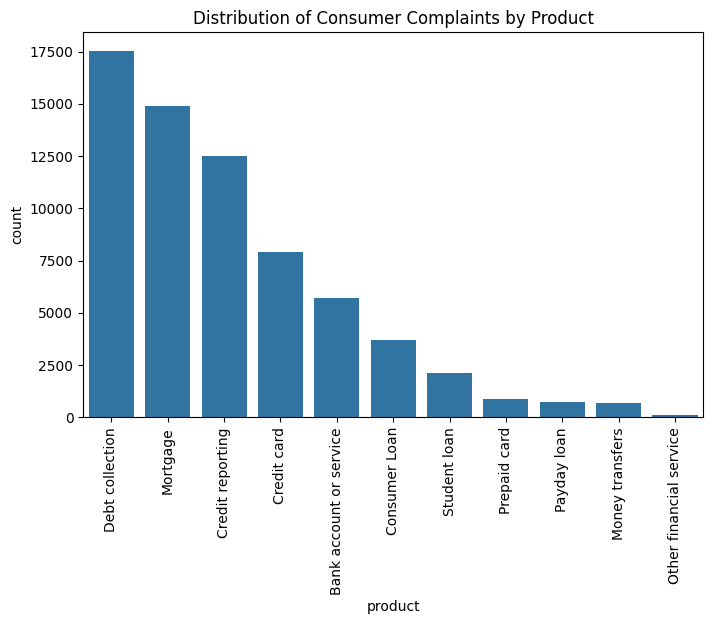

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot to visualize the distribution of consumer complaints by product
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='product', data=classification_data, ax=ax, order=classification_data['product'].value_counts().index)
plt.xticks(rotation=90, ha='center')  # Rotate x-axis labels to be straight
plt.title('Distribution of Consumer Complaints by Product')
plt.show()


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Initialize TF-IDF vectorizer
# 'analyzer' specifies whether to analyze words or characters
# 'token_pattern' defines the regular expression for identifying tokens (words in this case)
# 'max_features' limits the number of features to the top 5000 by term frequency
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)

# Fit the vectorizer on the consumer_complaint_narrative data
tfidf_vect.fit(classification_data['consumer_complaint_narrative'])

# Transform the consumer_complaint_narrative data into TF-IDF features
Features = tfidf_vect.transform(classification_data['consumer_complaint_narrative'])

# Use LabelEncoder to convert product labels into numerical format
encoder = preprocessing.LabelEncoder()
Labels = encoder.fit_transform(classification_data['product'])

In [8]:
print(Features[0], Labels)

  (0, 4980)	0.19946692590518458
  (0, 4967)	0.08367785689944471
  (0, 4528)	0.03945843468300431
  (0, 4486)	0.05079420833765883
  (0, 4475)	0.05074380583274784
  (0, 4466)	0.20886092796068428
  (0, 4464)	0.08214182747432149
  (0, 4462)	0.04046932892633899
  (0, 4290)	0.13501006475169727
  (0, 4063)	0.08953356522886974
  (0, 3495)	0.13173594877936717
  (0, 3270)	0.08506969605084602
  (0, 3229)	0.0916469670914765
  (0, 3210)	0.24774356329679265
  (0, 3115)	0.046174555519359825
  (0, 2845)	0.05348433820104951
  (0, 2518)	0.2246454974653814
  (0, 2449)	0.23373093275704698
  (0, 2326)	0.2000394496046405
  (0, 2305)	0.10983925924295175
  (0, 2215)	0.07212388567496104
  (0, 2200)	0.18464139378136915
  (0, 2031)	0.20026770337237787
  (0, 1994)	0.15112095802707426
  (0, 1457)	0.1633685106412558
  (0, 1199)	0.13429597623199974
  (0, 1056)	0.10694069345312737
  (0, 1011)	0.1716552590907946
  (0, 977)	0.11978819231338515
  (0, 881)	0.20696270632845382
  (0, 878)	0.08642368937977245
  (0, 762)	0.12

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_x, valid_x, train_y, valid_y = train_test_split(
    classification_data['consumer_complaint_narrative'],
    classification_data['product'],
    test_size=0.25,  # 25% of the data will be used as the test dataset
    random_state=42  # Setting a random seed for reproducibility
)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Initialize LabelEncoder to convert product labels into numerical format
encoder = preprocessing.LabelEncoder()

# Label encode the target variables for training and validation sets
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# Display the encoded labels for training set
print("Encoded Labels for Training Set:")
print(train_y)

# Initialize TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)

# Fit the vectorizer on the entire consumer_complaint_narrative data
tfidf_vect.fit(classification_data['consumer_complaint_narrative'])

# Display stop words used by the TF-IDF vectorizer
print("\nStop Words used by TF-IDF Vectorizer:")
print(tfidf_vect.stop_words)

# Display vocabulary (word to index mapping) created by the TF-IDF vectorizer
print("\nVocabulary (Word to Index Mapping) created by TF-IDF Vectorizer:")
print(tfidf_vect.vocabulary_)

# Transform the training and validation text data into TF-IDF features
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

# Display the TF-IDF features for the first document in the training set
print("\nTF-IDF Features for the First Document in Training Set:")
print(xtrain_tfidf[0])

Encoded Labels for Training Set:
[ 6  4  3 ...  3  4 10]

Stop Words used by TF-IDF Vectorizer:
None

Vocabulary (Word to Index Mapping) created by TF-IDF Vectorizer:
{'xxxx': 4967, 'has': 2215, 'claimed': 1011, 'i': 2326, 'owe': 3210, 'them': 4466, '27': 108, '00': 1, 'for': 1994, 'years': 4980, 'despite': 1457, 'the': 4462, 'proof': 3495, 'of': 3115, 'payment': 3270, 'sent': 4063, 'canceled': 881, 'check': 977, 'and': 486, 'their': 4464, 'invoice': 2518, 'they': 4475, 'continue': 1199, 'to': 4528, 'insist': 2449, 'collection': 1056, 'agencies': 420, 'are': 562, 'after': 413, 'me': 2845, 'how': 2305, 'can': 878, 'stop': 4290, 'this': 4486, 'harassment': 2200, 'a': 274, 'bill': 762, 'already': 463, 'paid': 3229, 'four': 2031, 'ago': 426, 'due': 1610, 'in': 2373, 'amount': 479, 'owed': 3211, 'that': 4460, 'was': 4836, 'told': 4531, 'by': 858, 'm': 2771, 't': 4404, 'bank': 686, 'reported': 3797, 'credit': 1285, 'reporting': 3798, 'advised': 392, 'write': 4954, 'good': 2129, 'will': 4895,

In [11]:
print(xtrain_tfidf[0])

  (0, 4988)	0.05788173042287979
  (0, 4967)	0.17811089494521154
  (0, 4966)	0.36075661843559564
  (0, 4911)	0.03235186081195727
  (0, 4844)	0.07758300817561649
  (0, 4836)	0.030838202251006242
  (0, 4780)	0.10472415967005279
  (0, 4670)	0.14021638964127628
  (0, 4528)	0.07199013702178507
  (0, 4468)	0.05502334836215618
  (0, 4464)	0.04995468829079253
  (0, 4462)	0.09844595738923899
  (0, 4460)	0.028886689168546302
  (0, 4426)	0.127657782450991
  (0, 4389)	0.1645857988296623
  (0, 4380)	0.1610583846684241
  (0, 4314)	0.13757812606487166
  (0, 4284)	0.058608637363514744
  (0, 4145)	0.12286681050170098
  (0, 4144)	0.057543906360497075
  (0, 3983)	0.1117420832388338
  (0, 3933)	0.17778828674076166
  (0, 3774)	0.15852823922320317
  (0, 3657)	0.17049758956568048
  (0, 3356)	0.06666364277006928
  :	:
  (0, 2193)	0.09201779351314462
  (0, 2052)	0.10434286981219447
  (0, 2004)	0.25583304789031336
  (0, 1940)	0.149265424036568
  (0, 1939)	0.07093301780247992
  (0, 1935)	0.13824210632017175
  (0,

In [12]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
model = LogisticRegression()

# Train the model using the TF-IDF features (xtrain_tfidf) and encoded labels (train_y)
model.fit(xtrain_tfidf, train_y)

# Display that the model has been trained
print("Logistic Regression Model Trained Successfully!")


Logistic Regression Model Trained Successfully!


C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
display(model)

LogisticRegression()

In [14]:
from sklearn import metrics

def evaluate_model():
    # Predictions on the validation set using the trained model
    predictions = model.predict(xvalid_tfidf)

    # Calculate accuracy
    accuracy = metrics.accuracy_score(predictions, valid_y)
    print("Accuracy: ", accuracy)

    # Display classification report with additional information
    class_report = metrics.classification_report(valid_y, predictions, target_names=Data['product'].unique())
    print("Classification Report:")
    print(class_report)

# Call the evaluation function
evaluate_model()


Accuracy:  0.848401389055203
Classification Report:
                         precision    recall  f1-score   support

               Mortgage       0.81      0.80      0.80      1454
       Credit reporting       0.78      0.63      0.70       912
           Student loan       0.83      0.82      0.82      2039
        Debt collection       0.85      0.85      0.85      3110
            Credit card       0.82      0.89      0.85      4377
Bank account or service       0.84      0.51      0.64       180
          Consumer Loan       0.93      0.96      0.94      3687
        Money transfers       0.00      0.00      0.00        26
            Payday loan       0.63      0.20      0.30       193
           Prepaid card       0.79      0.63      0.70       202
Other financial service       0.89      0.82      0.85       522

               accuracy                           0.85     16702
              macro avg       0.74      0.65      0.68     16702
           weighted avg       0.84  

C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Confusion Matrix:
[[1158   11  110   36   58    7   48    0    0   26    0]
 [  21  574   45   73  131    0   52    0    9    0    7]
 [  87   10 1662   98  157    2   18    0    0    5    0]
 [  11   26   56 2650  299    1   52    0    3    0   12]
 [  31   46   80  195 3904    1   76    0    9    1   34]
 [  44    2   12    4   15   92    8    0    1    2    0]
 [  28   20    9   47   46    0 3537    0    0    0    0]
 [   7    1    1    1    9    3    3    0    0    0    1]
 [  12   40    4    4   89    0    6    0   38    0    0]
 [  28    1   28    2   11    3    1    0    0  128    0]
 [   4    3    5   12   49    0   22    0    0    0  427]]


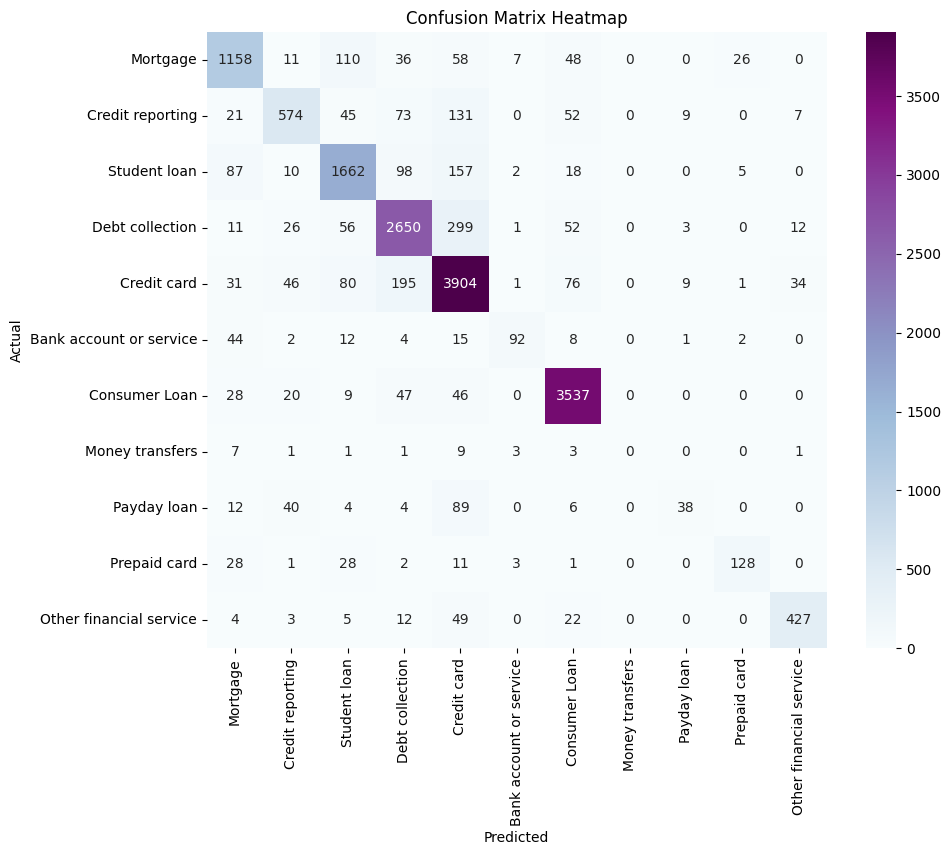

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def heat_conf():
    # Confusion matrix
    conf_mat = metrics.confusion_matrix(valid_y, model.predict(xvalid_tfidf))
    print("Confusion Matrix:")
    print(conf_mat)

    # Visualizing confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=Data['product'].unique(), yticklabels=Data['product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Call the function to generate and visualize the confusion matrix
heat_conf()


In [16]:
import pandas as pd

# Create an empty DataFrame to store category information
category_id_df = pd.DataFrame()

# Populate the 'category' column with unique product categories
category_id_df['category'] = Data['product'].unique()

# Assign numerical identifiers based on the index values
category_id_df['category_id'] = category_id_df.index.values

# Uncomment the line below to print the numerical identifiers
# print(category_id_df.index.values)

# Create a dictionary for mapping between category and numerical identifier
category_to_id = dict(category_id_df[['category_id', 'category']].values)

# Display the mapping between numerical identifiers and product categories
print("Category to ID Mapping:")
print(category_to_id)


Category to ID Mapping:
{0: 'Mortgage', 1: 'Credit reporting', 2: 'Student loan', 3: 'Debt collection', 4: 'Credit card', 5: 'Bank account or service', 6: 'Consumer Loan', 7: 'Money transfers', 8: 'Payday loan', 9: 'Prepaid card', 10: 'Other financial service'}


In [17]:
# Get the predicted probabilities for each class for the first 15 instances in the validation set
probabilities = model.predict_proba(xvalid_tfidf)
print(probabilities[:15, :])


[[1.27091445e-03 2.03434329e-03 3.81091910e-03 2.45556554e-02
  9.59301304e-01 3.45950172e-04 5.59158214e-03 3.38628097e-04
  6.63774147e-04 5.71126889e-04 1.51580249e-03]
 [1.38230982e-03 1.77376062e-03 2.06756905e-03 4.10335242e-03
  1.00893360e-02 5.11659328e-04 9.74367366e-01 3.94429648e-04
  1.01590480e-03 2.88668955e-04 4.00564364e-03]
 [7.43739299e-02 8.57760401e-02 4.61269386e-01 1.84761474e-02
  2.71956518e-01 4.89843884e-03 3.54268581e-02 3.50235079e-03
  1.54269696e-02 1.06270213e-02 1.82663399e-02]
 [4.40937775e-04 4.62419079e-03 4.27367094e-03 8.90339680e-01
  9.76288158e-02 3.14663226e-04 8.59121232e-04 2.25458263e-04
  5.73919180e-04 2.88166582e-04 4.31375741e-04]
 [6.60473294e-03 8.25337567e-03 6.39131514e-03 9.00652769e-01
  4.08865501e-02 3.12473849e-03 2.47359854e-02 9.00196471e-04
  2.27436056e-03 2.04186595e-03 4.13411040e-03]
 [3.10894501e-03 2.43707197e-02 9.35791838e-01 2.08330585e-03
  3.84037226e-03 5.08060482e-04 1.48412252e-02 3.63155825e-04
  5.59208998e-04

In [18]:
# Get the decision scores for each class for the first 15 instances in the validation set
y_score = model.decision_function(xvalid_tfidf)
print(y_score[:15, :])

# Make predictions for the first 15 instances in the validation set
predictions = model.predict(xvalid_tfidf)
print(predictions[:15])


[[-0.79461462 -0.32417824  0.3035191   2.1665909   5.83185392 -2.09581182
   0.68691098 -2.11720413 -1.44416462 -1.59449517 -0.6184063 ]
 [-0.65705335 -0.40770729 -0.25443568  0.43099507  1.33066979 -1.65090548
   5.90097917 -1.91112372 -0.96502959 -2.22328396  0.40689505]
 [ 0.86989197  1.01252621  2.69476872 -0.52273293  2.16642869 -1.85029696
   0.12825673 -2.18577911 -0.70309625 -1.07581357 -0.53415349]
 [-1.55518987  0.79496303  0.7161348   6.05526469  3.84483433 -1.8925907
  -0.8881836  -2.22595859 -1.29160505 -1.98055492 -1.57711414]
 [-0.25444735 -0.03161157 -0.2872938   4.66088594  1.5685673  -1.00288326
   1.06602522 -2.2473761  -1.32053492 -1.42836979 -0.72296169]
 [-0.26505885  1.7940401   5.44205076 -0.66538631 -0.05377299 -2.07649707
   1.2980665  -2.41226556 -1.98057429 -2.33019344  1.24959116]
 [-0.4944764  -0.07500775  0.67835891  6.31457699 -0.02141653 -1.21581853
  -0.24766387 -2.23166766 -1.57421068 -0.74643658 -0.38623791]
 [-2.21095708  1.12420264  1.98677725  3.8

In [19]:
# Binarize the output labels
y = preprocessing.label_binarize(valid_y, classes=[0,1,2,3,4,5,6,7,8,9,10])

# Get the number of classes
n_classes = y.shape[1]

# Display the binarized labels
print(y)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


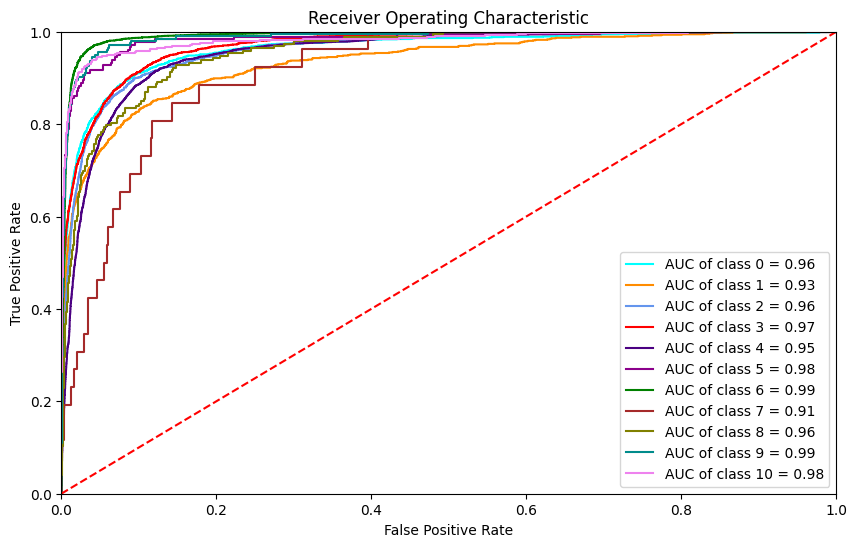

In [20]:
def plot_auc(labels, colours=['orange']):
    # Compute ROC curve and ROC area for each class
    n_classes = len(category_to_id)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute the false positive rate, true positive rate, and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(labels[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure(figsize=(10, 6))
    for i, color in zip(range(n_classes), colours):
        plt.plot(fpr[i], tpr[i], color=color, label='AUC of class {0} = {1:0.2f}'.format(i, roc_auc[i]))

    # Plot settings
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Example usage with colors specified
colours = ['aqua', 'darkorange', 'cornflowerblue', 'r', 'indigo', 'darkmagenta', 'green', 'brown', 'olive', 'darkcyan', 'violet']
plot_auc(y, colours)


Accuracy:  0.848401389055203


C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tebri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Report:
                         precision    recall  f1-score   support

               Mortgage       0.81      0.80      0.80      1454
       Credit reporting       0.78      0.63      0.70       912
           Student loan       0.83      0.82      0.82      2039
        Debt collection       0.85      0.85      0.85      3110
            Credit card       0.82      0.89      0.85      4377
Bank account or service       0.84      0.51      0.64       180
          Consumer Loan       0.93      0.96      0.94      3687
        Money transfers       0.00      0.00      0.00        26
            Payday loan       0.63      0.20      0.30       193
           Prepaid card       0.79      0.63      0.70       202
Other financial service       0.89      0.82      0.85       522

               accuracy                           0.85     16702
              macro avg       0.74      0.65      0.68     16702
           weighted avg       0.84      0.85      0.84     16702


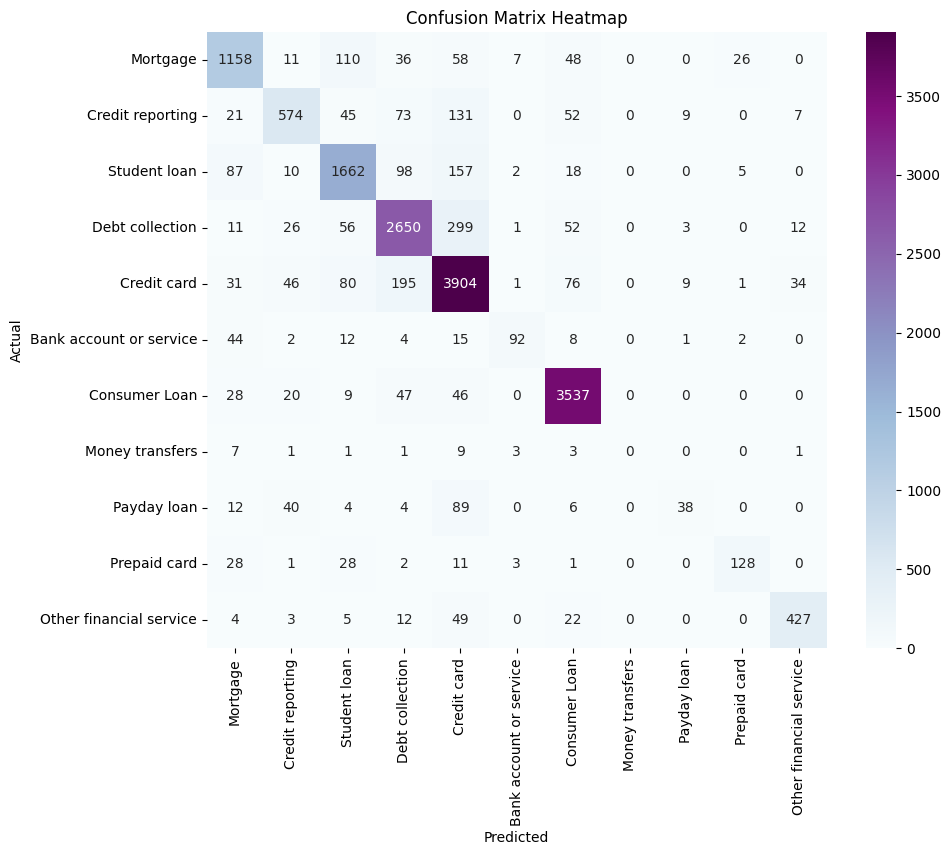

In [21]:
evaluate_model()
heat_conf()

In [26]:
# Assuming you have the reserved test dataset from the earlier split
test_indices = valid_x.index  # Get the indices used for the test set during the split

# Extract test data based on the indices
test_x = classification_data.loc[test_indices, 'consumer_complaint_narrative']

# Transform the test text data into TF-IDF features
xtest_tfidf = tfidf_vect.transform(test_x)

# Predictions on the test set using the trained model
test_predictions = model.predict(xtest_tfidf)

# Display the first 5 predictions
print("Predictions on Test Set (First 5):")
print(test_predictions[:5])


Predictions on Test Set (First 5):
[4 6 2 3 3]


In [27]:
# Use inverse_transform to convert numerical labels back to categorical names
predicted_categories = encoder.inverse_transform(test_predictions)

# Display the corresponding category names for the first 5 predictions
print("Predicted Categories for the First 5 Instances:")
print(predicted_categories[:5])


Predicted Categories for the First 5 Instances:
['Debt collection' 'Mortgage' 'Credit card' 'Credit reporting'
 'Credit reporting']


# In conclusion

Based on the complaint we can find out what category every complaint belongs to and send them to the appropriate department.